In [ ]:
import os
from PIL import Image
import torch
from src.utils.Dataset_loader import get_data_loaders_sample

In [22]:
dataset_paths_sample = { 'dataset3': '/kaggle/input/dataset/real-vs-fake/real-vs-fake'}
data_loaders_sample = get_data_loaders_sample(dataset_paths_sample, batch_size=32)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.utils.trigger_generator import TriggerGenerator, embed_trigger
from src.attacks.bd_attacks import poison_data_training, poison_data_testing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, clean_test_loader, poisoned_test_loader):
    #evaluation on clean test data
    model.eval()
    correct = 0
    total = 0
    y_true_clean, y_pred_clean = [], []
    with torch.no_grad():
        for inputs, labels in clean_test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true_clean.extend(labels.cpu().numpy())
            y_pred_clean.extend(predicted.cpu().numpy())
    clean_accuracy = (correct/total)*100
    print(f'Accuracy on clean test data: {clean_accuracy}%')
    cm_clean = confusion_matrix(y_true_clean, y_pred_clean)
    disp_clean = ConfusionMatrixDisplay(confusion_matrix=cm_clean, display_labels=['Fake', 'Real'])
    disp_clean.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix on clean test data')
    plt.show()
    fpr_clean, tpr_clean, _ = roc_curve(y_true_clean, y_pred_clean)
    auc_clean = roc_auc_score(y_true_clean, y_pred_clean)
    plt.plot(fpr_clean, tpr_clean, label=f"Clean Data (AUC = {auc_clean:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Clean Data")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    #Evaluation on poisoned test data
    y_true_poisoned, y_pred_poisoned = [], []
    with torch.no_grad():
        for inputs, labels in poisoned_test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true_poisoned.extend(labels.cpu().numpy())
            y_pred_poisoned.extend(predicted.cpu().numpy())
    cm_poisoned = confusion_matrix(y_true_poisoned, y_pred_poisoned)
    disp_poisoned = ConfusionMatrixDisplay(confusion_matrix=cm_poisoned, display_labels=['Fake', 'Real'])
    disp_poisoned.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix on poisoned test data')
    plt.show()
    fpr_poisoned, tpr_poisoned, _ = roc_curve(y_true_poisoned, y_pred_poisoned)
    auc_poisoned = roc_auc_score(y_true_poisoned, y_pred_poisoned)
    plt.plot(fpr_poisoned, tpr_poisoned, label=f"Poisoned Data (AUC = {auc_poisoned:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Poisoned Data")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    # Combined evaluation
    y_true_combined = y_true_clean+y_true_poisoned
    y_pred_combined = y_pred_clean+y_pred_poisoned
    cm = confusion_matrix(y_true_combined, y_pred_combined)
    disp_combined = ConfusionMatrixDisplay(cm, display_labels=['Fake', 'Real'])
    disp_combined.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix on combined test data')
    plt.show()
    fpr_combined, tpr_combined, _ = roc_curve(y_true_combined, y_pred_combined)
    auc_combined = roc_auc_score(y_true_combined, y_pred_combined)
    plt.plot(fpr_combined, tpr_combined, label=f"Combined Data (AUC = {auc_combined:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Combined Data")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    return clean_accuracy

# Backdoor attacks

In [10]:
import torch.nn.functional as F
trigger_generator = TriggerGenerator()
trigger_generator.load_state_dict(torch.load('/kaggle/input/erthkgf/pytorch/default/1/generator.pth', weights_only=True))
trigger_generator = trigger_generator.to(device)
trigger_generator.eval()

TriggerGenerator(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# seperating clean and poisoned sets

In [23]:
poisoned_test_loader1, clean_test_loader1= poison_data_testing(data_loaders_sample['dataset3']['test'], trigger_generator, poison_ratio=0.1)

Accuracy on clean test data: 87.47931605074463%


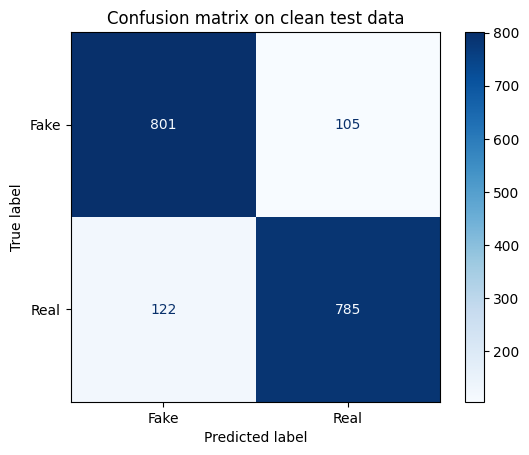

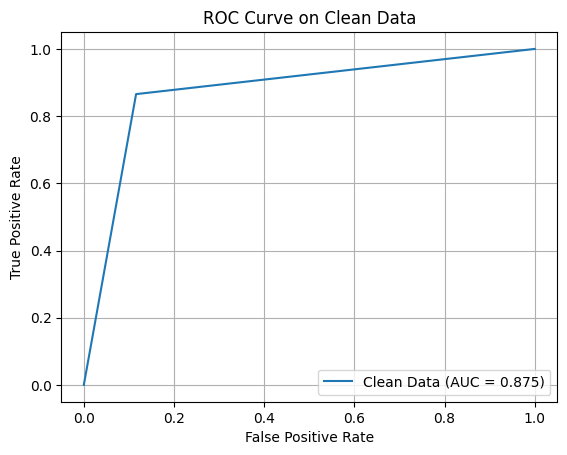

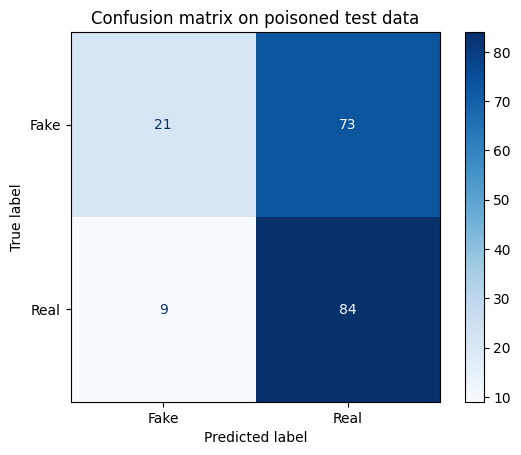

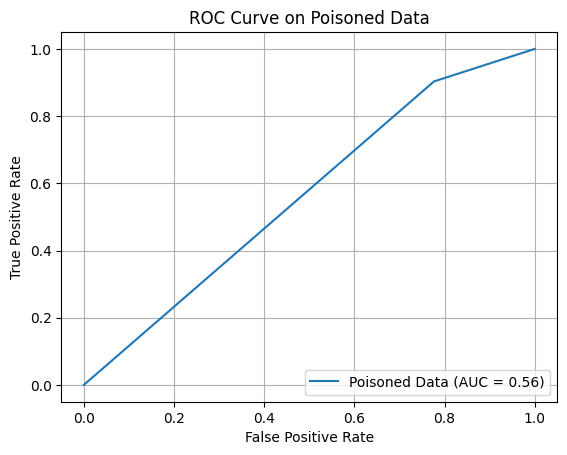

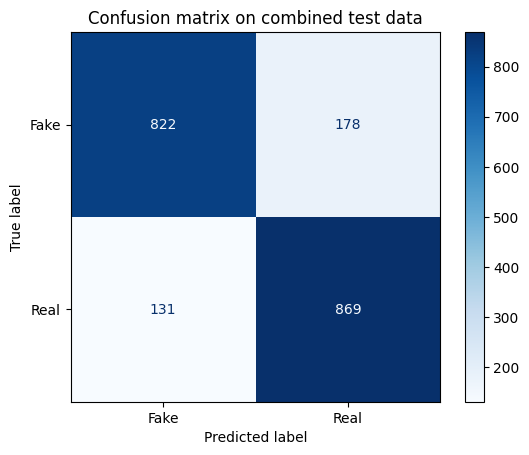

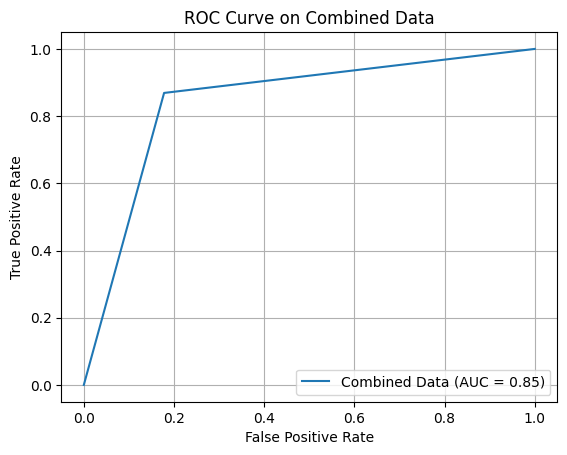

In [ ]:
from src.utils.Model import MobileNetV3Model
model1 = MobileNetV3Model(num_classes=2).to(device)
model_weights_path1 = '/kaggle/input/bd_attacked_models/pytorch/default/1/dataset3_BDmodel.pth'
model1.load_state_dict(torch.load(model_weights_path1, map_location = torch.device(device), weights_only=True))
evaluate_model(model1, clean_test_loader1, poisoned_test_loader1)

# Backdoor detection

Clean Means - Mean: -1.2531, Std: 0.8071
Poison Means - Mean: -0.9969, Std: 0.7890


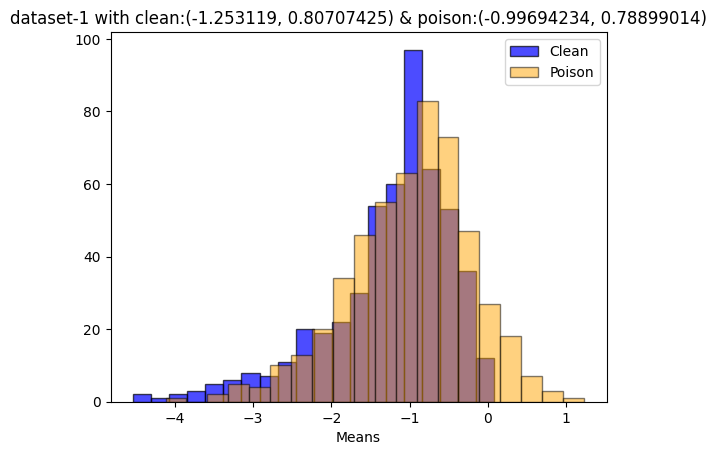

In [ ]:
from src.defender.bd_detection import register, collect_activations, compute_distributions

def plot_distributions(clean_distributions, poison_distributions, layer_name):
    clean_means = clean_distributions[layer_name][0]
    poison_means = poison_distributions[layer_name][0]
    clean_mean_val = clean_means.mean()
    clean_std_val = clean_means.std()
    poison_mean_val = poison_means.mean()
    poison_std_val = poison_means.std()
    print(f"Clean Means - Mean: {clean_mean_val:.4f}, Std: {clean_std_val:.4f}")
    print(f"Poison Means - Mean: {poison_mean_val:.4f}, Std: {poison_std_val:.4f}")
    plt.hist(clean_means, bins=20, alpha=0.7, label='Clean', color='blue', edgecolor='black')
    plt.hist(poison_means, bins=20, alpha=0.5, label='Poison', color='orange', edgecolor='black')
    plt.title(f'dataset-1 with clean:{clean_mean_val, clean_std_val} & poison:{poison_mean_val, poison_std_val}')
    plt.xlabel('Means')
    plt.legend()
    plt.show()

activations_storage = {'clean':{}, 'test':{}, 'poison':{}}
register(model1, mode='clean')
collect_activations(model1, clean_test_loader1, mode='clean')
register(model1, mode='poison')
collect_activations(model1, poisoned_test_loader1, mode='poison')
clean_distributions = compute_distributions(activations_storage['clean'])
poison_distributions = compute_distributions(activations_storage['poison'])
plot_distributions(clean_distributions, poison_distributions, 'last_layer')

In [ ]:
from src.defender.bd_detection import compute_nas_scores, compute_threshold, detect_backdoor

register(model1, mode='clean')
collect_activations(model1, clean_test_loader1, mode='clean')
# Compute clean activation distributions
clean_distributions = compute_distributions(activations_storage['clean'])
nas_scores = compute_nas_scores(model1, clean_test_loader1, clean_distributions, mode='clean')
# Compute NAS threshold for a given rejection rate
rejection_rate = 35  # Adjust based on requirement
threshold = compute_threshold(nas_scores, rejection_rate)
print(f"Threshold computed: {threshold}")
# Detect backdoor samples in the test set
register(model1, mode='test')
classifications = detect_backdoor(model1, poisoned_test_loader1, clean_distributions, threshold, mode='test')
# Count and report backdoor samples
backdoor_count = classifications.count(1)
print(f'Backdoor detected samples: {(backdoor_count / len(classifications)) * 100:.2f}%')

Threshold computed: 0.9964599609375
Backdoor detected samples: 100.00%


# Backdoor purification

Epoch:[1/5], Loss:1928383.2852, Accuracy:78.5438, AUC:0.8985
Epoch:[2/5], Loss:541770.2632, Accuracy:78.5438, AUC:0.8978
Epoch:[3/5], Loss:126566.1678, Accuracy:78.1577, AUC:0.8839
Epoch:[4/5], Loss:25844.1857, Accuracy:72.3662, AUC:0.8199
Accuracy dropped below the threshold. stopping purification
Confusion Matrix:


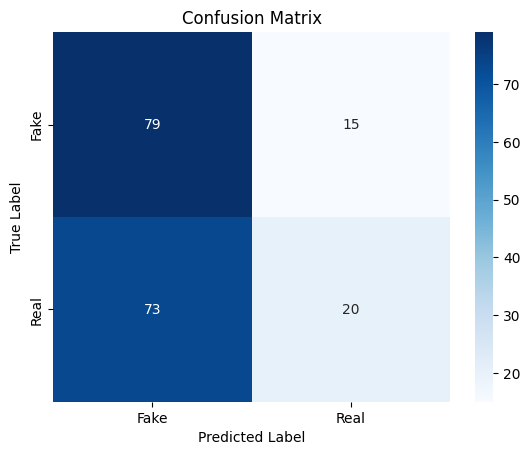

ROC AUC: 0.6400


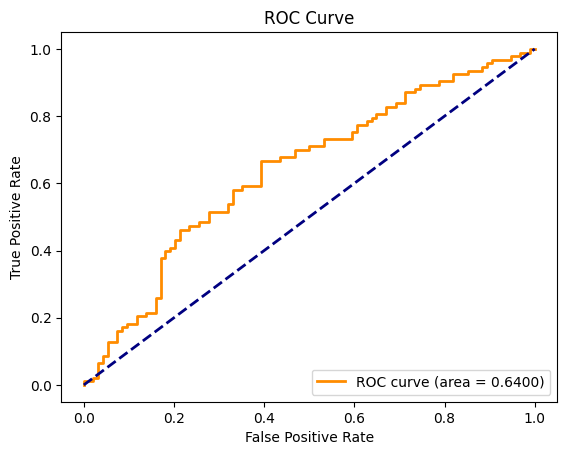

In [ ]:
from src.defender.backdoor_purification import purify_activations, evaluate_model_with_bounds_and_metrics
layer_name = 'last_layer'
clean_means = clean_distributions[layer_name][0]  # This is a tensor or list of clean means for each index
clean_stds = clean_distributions[layer_name][1]  # This is a tensor or list of clean stds for each index
clean_means = torch.tensor(clean_means, device=device, dtype=torch.float32)
clean_stds = torch.tensor(clean_stds, device=device, dtype=torch.float32)
# Create z_low and z_up for each index in the layer
z_low = torch.empty(512, device=device)  # No requires_grad at this point
z_up = torch.empty(512, device=device)

# Calculate the corresponding values for z_low and z_up
z_low = clean_means - 10* clean_stds
z_up = clean_means + 10 * clean_stds
# Make sure that z_low and z_up require gradients
z_low = z_low.requires_grad_()
z_up = z_up.requires_grad_()
# Purify activations
purify_activations(model1, clean_test_loader1, device, z_low, z_up, min_accuracy=75, num_epochs=5)
poisoned_accuracy1, poisoned_cm1, poisoned_roc_auc1 = evaluate_model_with_bounds_and_metrics(
    model1, poisoned_test_loader1, device, z_low, z_up
)
# Save model with bounds
torch.save({
    'model_state_dict': model1.state_dict(),
    'z_low': z_low,
    'z_up': z_up
}, 'model_with_bounds.pth')